# Multi-dimensional datasets

This is the continuation of [1-D datasets and tables](introduction.ipynb).

## Creation, slicing, and visualization

In [1]:
import numpy as np
import scipp as sc
from scipp.plot import plot

To create variables with more than one dimension we specify a list of dimension labels and provide data with a corresponding shape.
When inserted into a dataset it is important to note that while the dimensions extents have to match, individual variables may have transposed memory layout.

In [2]:
d = sc.Dataset(
    {
    'alice': sc.Variable(['z', 'y', 'x'], values=np.random.rand(10, 10, 10),
                         variances=0.1*np.random.rand(10, 10, 10)),
    'bob': sc.Variable(['x', 'z'], values=np.arange(0.0, 10.0, 0.1).reshape(10, 10),
                       variances=0.1*np.random.rand(10, 10))
    },
    coords={
        'x': sc.Variable(['x'], values=np.arange(11.0), unit=sc.units.m),
        'y': sc.Variable(['y'], values=np.arange(11.0), unit=sc.units.m),
        'z': sc.Variable(['z'], values=np.arange(11.0), unit=sc.units.m)})

Note that in this example the coordinates are exceeding the shape of the data by 1.
 This means that the coordinates represent bin edges:

In [3]:
sc.show(d)
d

<scipp.Dataset>
Dimensions: {{y, 10}, {z, 10}, {x, 10}}
Coordinates:
    y                         float64    [m]              (y [bin-edges])  [0.000000, 1.000000, ..., 9.000000, 10.000000]
    z                         float64    [m]              (z [bin-edges])  [0.000000, 1.000000, ..., 9.000000, 10.000000]
    x                         float64    [m]              (x [bin-edges])  [0.000000, 1.000000, ..., 9.000000, 10.000000]
Data:
    alice                     float64    [dimensionless]  (z, y, x)  [0.646235, 0.878849, ..., 0.338807, 0.109081]  [0.002928, 0.068429, ..., 0.044848, 0.066324]
    bob                       float64    [dimensionless]  (x, z)  [0.000000, 0.100000, ..., 9.800000, 9.900000]  [0.026604, 0.021431, ..., 0.017847, 0.015753]

To slice in multiple dimensions, we can simply chain the slicing notation used previously for 1D data.
This gives us a number of different options for visualizing our data:

In [4]:
sc.table(d['x', 5]['z', 2])

We can plot and item of a `Dataset` using:

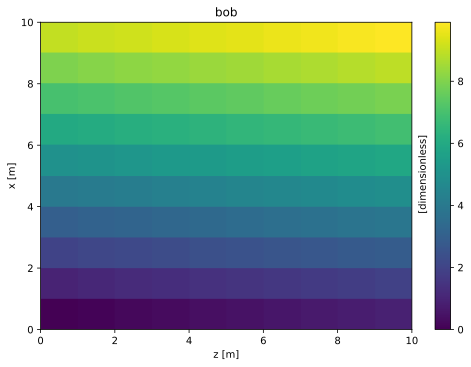

In [5]:
plot(d['bob'])

We can also plot the standard deviations, i.e., the square root of the variances stored in the dataset, alongside the values with:

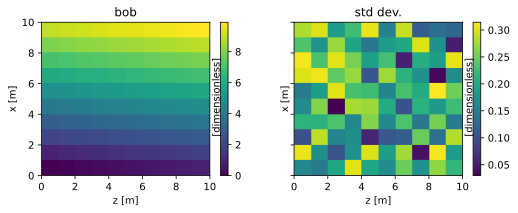

In [6]:
plot(d['bob'], variances=True)

Plotting a 3-dimensional data cube will show a 2D image with a slider to navigate through the third dimension (note that interactive sliders will only appear in a Jupyter notebook and not in the documentation pages):

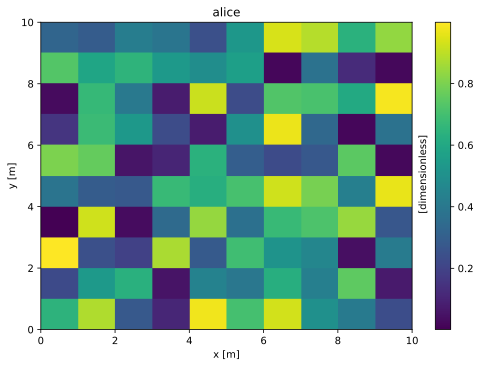

In [7]:
plot(d['alice'])

Finally, by extracting a 1D variable, we obtain a 1D plot:

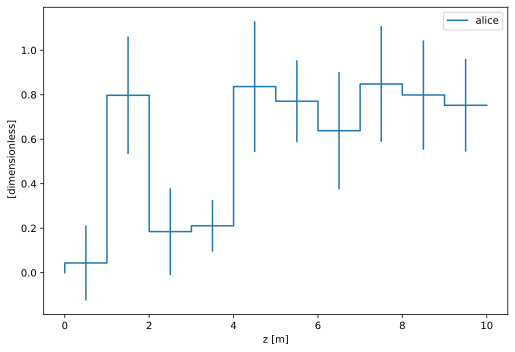

In [8]:
plot(d['x', 8]['y', 2])

Note that this is now plotted as a histogram since the coordinate in the dataset represents bin edges, in contrast to the 1D data plotted in [1-D datasets and tables](introduction.ipynb).

Operations automatically broadcast based on dimension labels.
That is, if one of the operands lacks one (or multiple) dimensions that the other operands have, the operand is considered constant along those dimensions.
Its values are implicitly "duplicated" so the shape matches.
In contrast to `numpy` or `MATLAB` there is no need to keep track of dimension order:

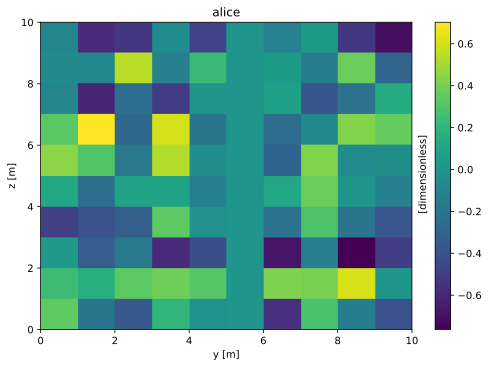

In [9]:
d['alice'] -= d['bob']
d['alice'] -= d['alice']['y', 5]
plot(d['alice']['x', 4])

### Exercise 1

Remove the X and Z surface layer of the volume, i.e., remove the first and last slice in each of the dimensions `'x'` and `'z'`.

### Solution 1

In [10]:
d = d['x', 1:-1]['z', 1:-1].copy()
d

<scipp.Dataset>
Dimensions: {{x, 8}, {y, 10}, {z, 8}}
Coordinates:
    z                         float64    [m]              (z [bin-edges])  [1.000000, 2.000000, ..., 8.000000, 9.000000]
    x                         float64    [m]              (x [bin-edges])  [1.000000, 2.000000, ..., 8.000000, 9.000000]
    y                         float64    [m]              (y [bin-edges])  [0.000000, 1.000000, ..., 9.000000, 10.000000]
Data:
    alice                     float64    [dimensionless]  (z, y, x)  [-0.171546, 0.513712, ..., 0.510170, -0.945215]  [0.118696, 0.337723, ..., 0.182468, 0.100702]
    bob                       float64    [dimensionless]  (x, z)  [1.100000, 1.200000, ..., 8.700000, 8.800000]  [0.029314, 0.010648, ..., 0.089190, 0.030448]

Note the important call to `copy()`.
If we omit it, `d` will just be a multi-dimensional slice of the larger volume (which is kept alive), wasting memory and preventing further modification, such as insertion of other variables.

Note also that if we had also sliced `'y'` the result would not contain the data for `'bob'` since this item does not depend on Y.

## More advanced operations with multi-dimensional datasets
Operations like `concatenate` and `merge` work just like with one-dimensional datasets.

### Exercise 2
- Try to concatenate the dataset with itself along the X dimensions. Why does this fail?
- Make a copy of the dataset, add an offset to the X coordinate to fix the issue, and try to concatenate again.

### Solution 2

In [11]:
try:
    d = sc.concatenate(d, d, 'x')
except RuntimeError:
    print("Failed as expected!")

Failed as expected!


With a data extent of, e.g. `8` in this case, bin edges have extent `9`.
Naive concatenation would thus lead a new data extent of `16` and a coordinate extent of `18`, which is meaningless and thus prevented.
In this `concatenate` merges the last edge of the first input with the first edge of the second input, if compatible.

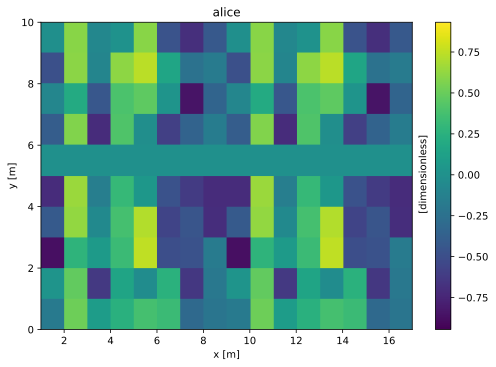

In [12]:
offset = d.copy()
offset.coords['x'] += sc.Variable(8.0, unit=sc.units.m)
combined = sc.concatenate(d, offset, 'x')
plot(combined['alice'])

Another available operation is `rebin`.
 This is only for count-data or count-density-data, so we have to set an appropriate unit first:

In [13]:
d['alice'].unit = sc.units.counts
d['bob'].unit = sc.units.counts

Before `rebin` we have the following:

<scipp.Dataset>
Dimensions: {{x, 8}, {y, 10}, {z, 8}}
Coordinates:
    z                         float64    [m]              (z [bin-edges])  [1.000000, 2.000000, ..., 8.000000, 9.000000]
    x                         float64    [m]              (x [bin-edges])  [1.000000, 2.000000, ..., 8.000000, 9.000000]
    y                         float64    [m]              (y [bin-edges])  [0.000000, 1.000000, ..., 9.000000, 10.000000]
Data:
    alice                     float64    [counts]         (z, y, x)  [-0.171546, 0.513712, ..., 0.510170, -0.945215]  [0.118696, 0.337723, ..., 0.182468, 0.100702]
    bob                       float64    [counts]         (x, z)  [1.100000, 1.200000, ..., 8.700000, 8.800000]  [0.029314, 0.010648, ..., 0.089190, 0.030448]

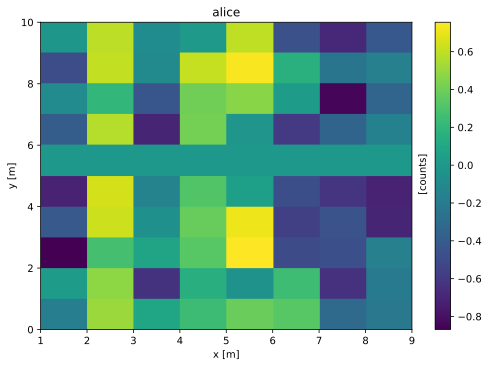

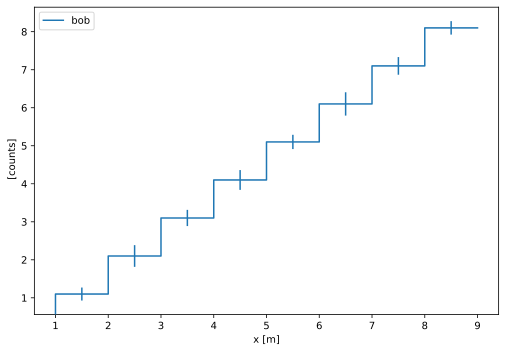

In [14]:
plot(d['z', 0])
d

We rebin onto a coarser grid, in this case combining two neightboring bins:

In [15]:
new_x = sc.Variable(['x'], values=d.coords['x'].values[::2])
d = sc.rebin(d, 'x', new_x)

The result looks as follows:

<scipp.Dataset>
Dimensions: {{y, 10}, {z, 8}, {x, 4}}
Coordinates:
    y                         float64    [m]              (y [bin-edges])  [0.000000, 1.000000, ..., 9.000000, 10.000000]
    z                         float64    [m]              (z [bin-edges])  [1.000000, 2.000000, ..., 8.000000, 9.000000]
    x                         float64    [dimensionless]  (x [bin-edges])  [1.000000, 3.000000, ..., 7.000000, 9.000000]
Data:
    alice                     float64    [counts]         (z, y, x)  [0.342166, 0.334270, ..., -0.370484, -0.435045]  [0.456419, 0.387615, ..., 0.484072, 0.283170]
    bob                       float64    [counts]         (x, z)  [3.200000, 3.400000, ..., 16.400000, 16.600000]  [0.111392, 0.035622, ..., 0.132007, 0.066447]

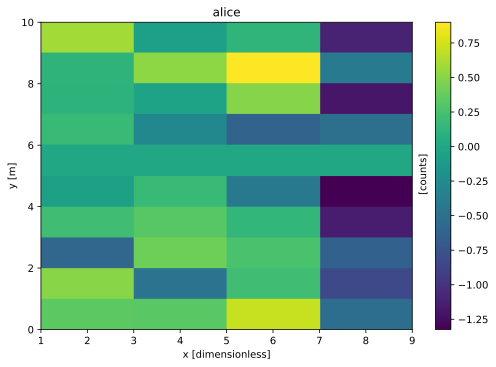

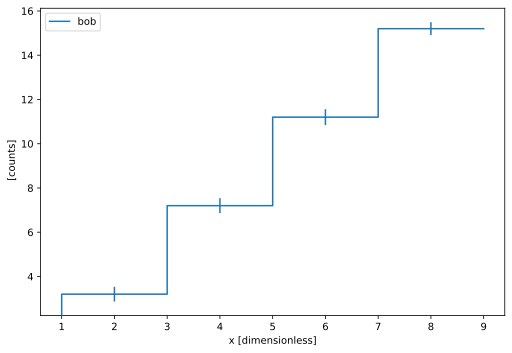

In [16]:
plot(d['z', 0])
d

## Interaction with `numpy`

Variable in a dataset are exposed in a `numpy`-compatible buffer format, so we can directly hand them to `numpy` functions:

In [17]:
d['alice'].values = np.sin(d['alice'].values)

In contrast to the 1-D case considered earlier, the `values` are now a multi-dimensional array:

In [18]:
d['alice'].values

array([[[ 0.33552816,  0.3280793 ,  0.65359925, -0.50002376],
        [ 0.48227795, -0.46111883,  0.21370385, -0.74125824],
        [-0.55690386,  0.40118881,  0.26010845, -0.59211173],
        [ 0.21323602,  0.31991289,  0.15062999, -0.91385768],
        [-0.05728495,  0.17018592, -0.4149581 , -0.96975401],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.18071378, -0.2818546 , -0.57499629, -0.48194313],
        [ 0.1171954 , -0.03366886,  0.47300728, -0.92684829],
        [ 0.1212978 ,  0.4993752 ,  0.78292923, -0.3902256 ],
        [ 0.55403964, -0.06780774,  0.13233878, -0.8956176 ]],

       [[-0.52687459,  0.03154631, -0.68940913, -0.18864622],
        [ 0.481641  ,  0.22506602, -0.03075924,  0.30264041],
        [-0.33954893,  0.42550743,  0.28487431, -0.21304885],
        [ 0.0671618 , -0.15688497, -0.28828241,  0.20905055],
        [-0.48551972, -0.42279277,  0.48020148,  0.52794186],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
      

### Exercise 3
 1. Use `sc.mean` to compute the mean of the data for Alice along the Z dimension.
 2. Do the same with `numpy`, what are the complications you encounter, that are not present when using the dataset?

### Solution 3

In [19]:
help(sc.mean)

Help on built-in function mean in module scipp._scipp.core:

mean(...) method of builtins.PyCapsule instance
    mean(*args, **kwargs)
    Overloaded function.
    
    1. mean(x: scipp._scipp.core.VariableConstView, dim: scipp._scipp.core.Dim) -> scipp._scipp.core.Variable
    
    
            Element-wise mean over the specified dimension, if variances are present, the new variance is computated as standard-deviation of the mean.
    
            If the input has variances, the variances stored in the ouput are based on the "standard deviation of the mean", i.e., :math:`\sigma_{mean} = \sigma / \sqrt{N}`.
            :math:`N` is the length of the input dimension.
            :math:`sigma` is estimated as the average of the standard deviations of the input elements along that dimension.
            This assumes that elements follow a normal distribution.
    
            :raises: If the dimension does not exist, or the dtype cannot be summed, e.g., if it is a string
            :see

In [20]:
mean = sc.mean(d['alice'], 'z')

When using `numpy` to compute the mean:
- We must remember (or lookup) which dimension corresponds to the Z dimensions.
- We need a separate call for values and variances.
- We need to manually scale the variance with the inverse of the number of data points to get the variance of the mean (standard deviation of the mean scales with `1/sqrt(N)`).

In [21]:
np_values = np.mean(d['alice'].values, axis=0)
np_variances = np.mean(d['alice'].variances, axis=0)
np_variances /= d['alice'].shape[0]

In [22]:
print(mean.values)
print(mean.variances)
print(np_values)
print(np_variances)

[[-0.01073749 -0.02811113  0.18229087 -0.19800055]
 [-0.24550577 -0.2043755   0.13664902  0.02653937]
 [-0.23987507  0.05291274  0.11801987  0.05501553]
 [ 0.11318817 -0.00048005 -0.19866793 -0.15337264]
 [-0.17828009  0.01702717  0.21248018  0.00392824]
 [ 0.          0.          0.          0.        ]
 [ 0.00121847 -0.17921371  0.08476498  0.11120764]
 [-0.16333228  0.2202968   0.09062603 -0.12052715]
 [-0.04463356 -0.11619716  0.00965622 -0.08121698]
 [ 0.05333199  0.1047359   0.15407102 -0.19271635]]
[[0.04810581 0.05054135 0.04934372 0.04862098]
 [0.0495877  0.04534242 0.05039847 0.04936926]
 [0.04799732 0.0480051  0.04812152 0.0496587 ]
 [0.04608515 0.04705873 0.05010761 0.04778581]
 [0.04600619 0.04805017 0.04846612 0.04971186]
 [0.04960951 0.04920875 0.04807221 0.04946805]
 [0.04886797 0.05075553 0.05263666 0.0499609 ]
 [0.04572647 0.04854386 0.04899732 0.05001541]
 [0.04522901 0.04756929 0.04976607 0.0463751 ]
 [0.04409207 0.0451429  0.05062774 0.04768548]]
[[-0.01073749 -0.0

Continue to [Neutron data](neutron-data.ipynb) to see how datasets are used with neutron-event data.